# Facial Expression Recognition Project

## Introduction and Motivation

This notebook is an exploratory project in CNN's and their application to facial expressions. A old kaggle competition from 2013 (https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge) which levaraged the FER2013 dataset was used as a general baseline to see how well the models in this project performed. This project is divided into 2 types of modeling:
1. Transfer Learning using the VGG19 model trained on the ImageNet dataset
2. 3 custom CNN's were developed and trained specifically on this dataset

Each model is compared to the competition results at the end of the notebook, with some notes for potential future work.

## Import Libraries

Import required libraries

In [1]:
# Basic
import re
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bisect import bisect_left

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras_flops import get_flops
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import models, layers, regularizers
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Model, Sequential, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Input, Concatenate, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Functions

Functions used throughout this notebook in order of first appearance.

In [8]:
def set_random_seed(seed):
    
    '''Random seeds for reproducability'''
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [2]:
def string_to_array(row):
    
    '''Transforms a string of separated values into an array of integers'''
    
    # apply list comprehension to split row using default criteria of split function and convert to array of integers
    return np.array([int(x) for x in row.split()])

In [3]:
def reshape_column(df, col_name, shape):
    
    '''Takes in a df, a target column containing arrays name and a tuple of desired array dimensions.
    Outputs a new dataframe with reshaped arrays.'''
    
    # copy dataframe 
    reshaped_df = df.copy()
    
    # apply string_to_array function to each row in df
    reshaped_df[col_name] = reshaped_df[col_name].apply(lambda x: x.reshape(shape))
    return reshaped_df

In [4]:
def emotion_example(emotion, dataframe):
    
    '''Pulls out a random example of an emotion from a dataframe. Note dataframe images must be in array format
    with shape: height x width x channels'''
    
    # pick a random entry from the indexes of that emotion
    entry = np.random.choice((dataframe[dataframe['emotion'] == emotion]).index)
    
    # filter result to that entry
    image = dataframe[dataframe['emotion'] == emotion].loc[entry, ' pixels']
    
    # plot
    fig = plt.figure(figsize = (3, 3))
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    plt.title(emotion_dict[emotion])
    plt.show()

In [5]:
def all_emotions(dataframe):
    
    '''Pulls out random examples of each emotion from a dataframe. Note dataframe images must be in array format
    with shape: height x width x channels'''
    
    # pick a random entry from the indexes of that emotion
    emotion_keys = np.arange(0, len(emotion_dict))
    
    # set up subplot variables
    nrows = 1
    ncols = len(emotion_keys)
    fig, axes = plt.subplots(nrows, ncols, figsize = (12, 12))
    
    # iterate through each emotion
    for i in emotion_keys:
        # generate index of example to pull out
        entry = np.random.choice((dataframe[dataframe['emotion'] == emotion_keys[i]]).index)
        
        # filter result to that entry
        image = dataframe[dataframe['emotion'] == emotion_keys[i]].loc[entry, ' pixels']

        # fill subplots
        axes[i].imshow(image, cmap = 'gray')
        axes[i].set_title(emotion_dict[emotion_keys[i]])
        axes[i].axis('off')
        
    plt.show()

In [6]:
def augment_column(df, col_name, datagen, n):
    
    '''Takes in a df with a column containing grayscale square image data in array form of dimensions (width, height, 1)
    and creates n number of augmented images. Returns a new dataframe containing original images and n new augmented 
    images, other column information conserved. Number of rows in augmented dataframe is 
    ((original_rows)*n + original_rows)'''
    
    # define shape based off input (assuing square and grayscale):
    width = df[col_name][0].shape[0]
    
    # reshape for datagen
    df_reshaped = reshape_column(df, col_name, (1, width, width, 1))
    
    def augment_row(row):
        # save original data (is rescaled and added to augmented data later)
        original_data = row[col_name]
        
        # intialize augmented data
        augmented_data = []
        
        # define image generator using 
        augmented_generator = datagen.flow(original_data, batch_size = 1)
        
        # iterate through number of desired augmented examples
        for _ in range(n):
            augmented_image = augmented_generator.next() # create augmented image
            augmented_row = row.copy() # copy all cols
            augmented_row[col_name] = augmented_image # replace with new augmented data
            augmented_data.append(augmented_row) # add to list of augmented images
            
        return pd.DataFrame(augmented_data)
    
    # apply augment_row function to every row in df:
    augmented_df = df_reshaped.apply(lambda row: augment_row(row), axis = 1)
    
    # rescale originals:
    df_reshaped[col_name] = df_reshaped[col_name] / 255.0
    
    # concatenate rescaled originals with augmented:
    augmented_df = pd.concat(augmented_df.tolist())
    df_aug = pd.concat([df_reshaped, augmented_df])
    
    # reshape back to original (48, 48, 1) shape
    return reshape_column(df_aug, col_name, df[col_name][0].shape)

In [7]:
def augmented_example(emotion, dataframe):
    
    '''Pulls out a random example of an augmentation from a dataframe. Returns original image plus each augmented example
    of that image. Note dataframe images must be in array format with shape: height x width x channels'''
    
    # pick a random entry from the indexes of that emotion
    entry = np.random.choice((dataframe[dataframe['emotion'] == emotion]).index)
    
    # filter result to those entries (note we have multiple identical row indexes from augmented function to group by)
    images = dataframe[dataframe['emotion'] == emotion].loc[entry, ' pixels']
    
    print('Emotion: ' + emotion_dict[emotion])
    # set up subplots
    nrows = 1
    ncols = len(images)
    fig, axes = plt.subplots(nrows, ncols, figsize = (12, 12))
    
    # iterate through images (1 original, n augmented):
    for i in range(ncols):
        
        # define image
        image = images.iloc[i]
        
        # fill subplots
        axes[i].imshow(image, cmap = 'gray')
        axes[i].axis('off')
        axes[0].set_title('Original')
        axes[i].set_title('Augmented ' + str(i))
        
    plt.show()

In [9]:
def model_convergence(histories):
    
    '''Takes in a dictionary of trained model histories (keys = model decsriptions, values = histories) and returns a 
    dataframe of varaibles at each epoch. '''
    
    # define dict of variables
    convergence_vars = {'Train Loss': 'loss',
                        'Train Accuracy': 'accuracy',
                        'Validation Loss': 'val_loss',
                        'Validation Accuracy': 'val_accuracy'}
    ncols = 2
    nrows = int(len(convergence_vars)/ncols)
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (9, 8))
    colors = sns.color_palette('colorblind', n_colors = len(histories))
    
   # iterate through variables to access history logs
    for var, axis in zip(convergence_vars.keys(), ax.flatten()):
        # iterate through model histories
        for model, history, color in zip(histories.keys(), histories.values(), colors):
            # note we create blank df and plot in this inner most loop as models may have different number of epochs, thus
            # we do not need to use padding in our df if each model is treated separately.
            df = pd.DataFrame() # intialize/re-initialize df for each model and variable
            string = re.split(' ', model)[0] # use first word in model name as defining string
            df[string] = history.history[convergence_vars[var]] # fill with model specific history variable data
            
            # add to plot (used matplot lib here instead of seaborn, easier to color each line separately)
            axis.plot(df.index + 1, df[string], color = color, label = string)
        axis.set_title(var)
        axis.set_ylabel(re.split(' ', var)[-1])
        axis.set_xlabel('Epoch')
        axis.legend()
        
    plt.tight_layout(pad = 2.0)
    plt.show()

In [10]:
def overfitting_check(histories, ncols = 2):
    
    '''Takes in a dictionary of histories (keys = model decsriptions, values = histories) and plots the training vs 
    validation accuracy for each model'''
    
    nrows = math.ceil(len(histories)/ncols)
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (9, nrows/ncols*8)) # rescale depending on rows,cols
    colors = sns.color_palette('colorblind', n_colors = len(histories))
    
    # iterate through model histories
    for model, history, axis in zip(histories.keys(), histories.values(), ax.flatten()):
        df = pd.DataFrame() # intialize df for each model and variable
        df['Train'] = history.history['accuracy']
        df['Validation'] = history.history['val_accuracy']
        df.index = df.index + 1 # add 1 to start at epoch 1
        sns.lineplot(data = df, ax = axis)
        axis.set_title(model)
        axis.set_ylabel('Accuracy Score')
        axis.set_xlabel('Epoch')
        
    # Remove any unused subplots
    for i in range(len(histories), nrows * ncols):
        plt.delaxes(ax.flatten()[i])
        
    plt.tight_layout(pad = 2.0)
    plt.show()

In [11]:
def compare_model_performance(model_dict, X_test_data, y_test_data):
    
    ''' Takes in a dictionary of models (keys = model decsriptions, values = trained models) and compares the accuracy and 
    loss when used to predict test data'''
    
    # create blank dataframe
    results = pd.DataFrame()
    results.index = ['loss', 'accuracy']
    
    # iterate through models
    for model_name, model in zip(model_dict.keys(), model_dict.values()):
        metrics = model.evaluate(X_test_data, y_test_data) # evaulate each model on data
        results[model_name] = metrics # store merics

    # plot (using matplot lib here istead of seaborn as data is not in long form)
    colors = sns.color_palette('colorblind', len(model_dict))
    results.plot(kind = 'bar', color = colors)
    plt.title('Model Performance Comparison on Test Data')
    plt.ylabel('Score')
    plt.xticks(rotation = 0)
    plt.show()

In [12]:
def confusion_matrix_generator(model, X_test_data, y_test_data):
    
    ''' Takes in a trained model and test data set, returns normalized confusion matrix'''
    
    # calculate the predicted labels for each test image.
    predict_probas = model.predict(X_test_data)
    y_predict = np.argmax(predict_probas, axis = 1)

    # create the confusion matrix using sklearn 
    conf_mat = confusion_matrix(y_test_data, y_predict)

    # since we have many images, it is helpful to show our results as fractions of the total number of images for each class.
    normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

    # plot matrix
    plt.figure(figsize = (6,5))
    sns.heatmap(normalized_conf_mat,
                annot = True,
                cbar = False,
                cmap = "mako",
                linewidths = 1)
    plt.title('Confusion Matrix')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [13]:
def classification_report_generator(model, X_test_data, y_test_data):
    
    '''Takes in a trained model and test data, creates a classification report'''
    
    # generate soft predictions using test data
    predict_probas = model.predict(X_test_data)
    
    # make hard predictions by taking the highest soft prediction value as the best guess
    y_pred = np.argmax(predict_probas, axis = 1)

    # display report using sklearn's built in report generator
    report = classification_report(y_test_data, y_pred)
    print(report)

## Data Overview

Before we begin lets set the random seed for our notebook for repeatability:

In [35]:
set_random_seed(42)

Read data into pandas dataframe and display first 5 rows:

In [14]:
df = pd.read_csv('data/icml_face_data.csv')

In [15]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


Let's see what our pixels col contains specifically:

In [16]:
image_1 = df[' pixels'][0]
print(f'Image in row 1 of dataframe is {type(image_1)} with length {len(image_1)}')

Image in row 1 of dataframe is <class 'str'> with length 8287


Okay this aligns with the data description on kaggle, lets look at the dataframe more broadly:

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


We have a total of 35887 images/rows with columns:
- 'emotion': categorical encoded emotions
- 'Usage': details of data subset use (train/test)
- 'pixels': a string of space separated pixel values

Let's look at our different groups of data by looking at the unique values within the 'Usage' col:

In [18]:
df[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

Note that 'PrivateTest' was made available only after the competition was closed. In order to fairly judge the performance of the models developed in this notebook, only 'Training' and 'PublicTest' will be used for model development. 'PrivateTest' will only be used as a final score to compare our model performance to other entries in the competition.

Now that we have a decent overview of our dataframe lets dive into our pixel data so we can visualize some of the images.

## Preprocessing Pixel Data

Apply our 'string_to_array' function to first create 1D arrays of pixel values:

In [19]:
df[' pixels'] = df[' pixels'].apply(string_to_array)

In [20]:
image_1 = df[' pixels'][0]
print(f'Image in row 1 of dataframe is now {type(image_1)} with length {len(image_1)}')

Image in row 1 of dataframe is now <class 'numpy.ndarray'> with length 2304


Quick check to see if this array length is equivalent to a flattened 48x48 single channel image:

In [21]:
48*48 == 2304

True

Great now lets reshape our images into width by height grayscale (48 x 48 x 1) using our 'reshape_column' function:

In [22]:
df_reshaped = reshape_column(df, ' pixels', (48, 48, 1))

In [23]:
image_1_reshaped = df_reshaped[' pixels'][0]
print(f'Image in row 1 of dataframe is now shape {image_1_reshaped.shape}')

Image in row 1 of dataframe is now shape (48, 48, 1)


Safe to assume all rows were reshaped sucessfully as function did not produce an error. Lets move on to creating relevant dataframes:

## Define Dataframes

For this project we will emulate the data made available to the competition participants by using only 'Training' and 'PublicTest' data during model development. 'PrivateTest' data will be used only at the end to see how our model(s) fair against other entries.

In [24]:
df_train = df_reshaped[df_reshaped[' Usage'] == 'Training']
df_test = df_reshaped[df_reshaped[' Usage'] == 'PublicTest']

Create a dictionary to map the encoded emotions as per data description:

In [25]:
emotion_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

## Brief EDA

### Class Distribution

First lets look at the class distributions of our images:

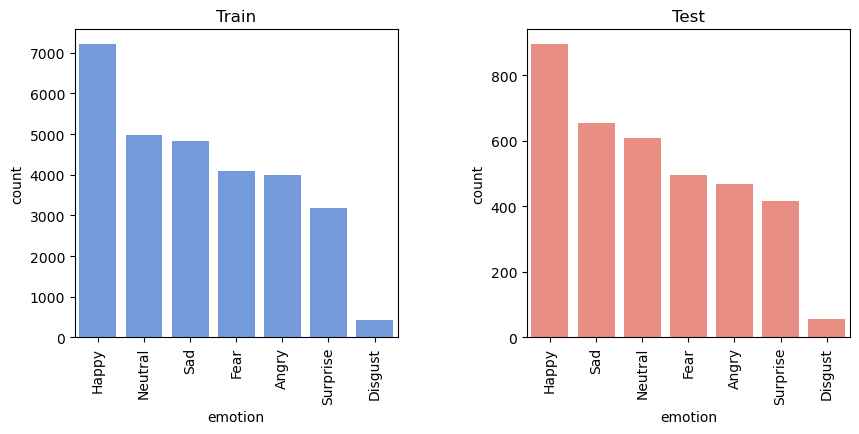

In [26]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), gridspec_kw={'wspace': 0.4}) # initialize subplot
dataframes_dict = {'Train': df_train, 'Test': df_test} # create dictionary of dataframes to analyze
colors = ['cornflowerblue', 'salmon']

# iterate through dataframe dictionary
for i, (df_name, df) in enumerate(zip(dataframes_dict.keys(), dataframes_dict.values())):
    
    # create class counts dataframe
    class_counts = pd.DataFrame(df['emotion'].value_counts().reset_index()) # calculate the counts for each emotion
    class_counts.columns = ['emotion', 'count'] # rename columns
    class_counts['emotion'] = class_counts['emotion'].map(lambda x: emotion_dict.get(x)) # comvert from encoded to emotions
    
    # fill subplot
    sns.barplot(data = class_counts, x = 'emotion', y = 'count', color = colors[i], ax = axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 90)
    axes[i].set_title(df_name)
    
plt.show()

In [27]:
train_count = df_train.groupby('emotion').size()
ratio = round(train_count.max() / train_count.min(), 1)
print(f'\'{emotion_dict.get(train_count.idxmax())}\' class is {ratio} times larger than \'{emotion_dict.get(train_count.idxmin())}\' class in the training dataset.')

'Happy' class is 16.5 times larger than 'Disgust' class in the training dataset.


We can see highly imbalanced data within both datasets. Based on this we will introduce class weightings in our models:

In [28]:
# calculate class proportions based on train data
class_weights = (train_count / len(df_train)).to_dict()
class_weights

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

### Visualize Images and Labels

Lets pull out some examples of these images and see what we are working with:

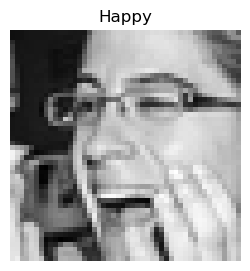

In [29]:
emotion_example(3, df_train)

By expanding the scope of the 'emotion_example' function we can look at examples of all the emotional tags:

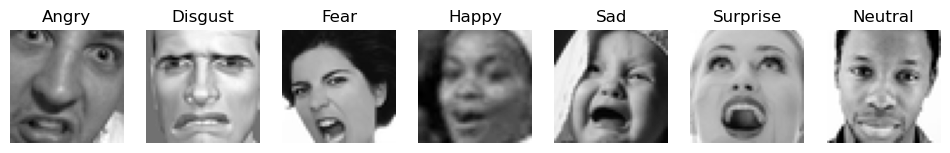

In [30]:
all_emotions(df_train)

## Augmentation

We will experiment with the use of image augmentation to try and improve model robustness and reduce the risk of overfitting.

### Pre-process Our Images

Note we will not crop our images as the dataset provided has ". . . been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image".

In [31]:
# define preprocessing operations from our training data:
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255.0,  # normalize pixel values to [0, 1]
    rotation_range = 40,  # randomly rotate images up to 40 degrees
    width_shift_range = 0.2,  # randomly shift width by up to 20%
    height_shift_range = 0.2,  # randomly shift height by up to 20%
    shear_range = 0.2,  # randomly shear by up to 20%
    horizontal_flip = True,  # randomly flip images horizontally
    fill_mode = 'nearest')  # how to fill newly created pixels after transformations

Apply this datagen using our 'augment_column' function:

In [32]:
df_train_aug = augment_column(df_train, ' pixels', train_datagen, 2)
df_train_aug.head()

,emotion,Usage,pixels
0,0,Training,"[[[0.27450980392156865], [0.3137254901960784],..."
1,0,Training,"[[[0.592156862745098], [0.5882352941176471], [..."
2,2,Training,"[[[0.9058823529411765], [0.8313725490196079], ..."
3,4,Training,"[[[0.09411764705882353], [0.12549019607843137]..."
4,6,Training,"[[[0.01568627450980392], [0.0], [0.0], [0.0], ..."


Lets check the output of our augmentation function by looking at an augmented example:

Emotion: Happy


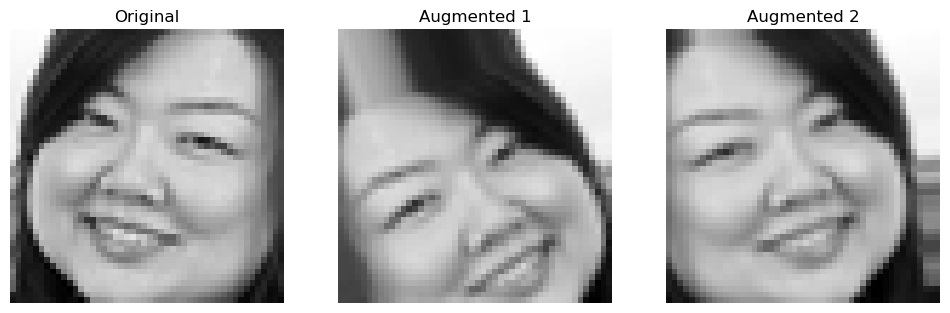

In [33]:
# look at our augmented images
augmented_example(3, df_train_aug)

Great it looks like our augmentation has behaved as expected. Next we will apply a rescale only to our data to use as our control to test the efficacy of using our augmented data:

In [34]:
# also create un-augmented training df for comparison, rescale only
df_train_rescaled = df_train.copy()
df_train_rescaled[' pixels'] = df_train_rescaled[' pixels'] / 255.0

# test data also scaled only
df_test_rescaled = df_test.copy()
df_test_rescaled[' pixels'] = df_test_rescaled[' pixels'] / 255.0

## Modeling

Now that our dataframes have been pre-processed, lets move on to model development

### Transfer Learning

First we apply transfer learning using the VGG19 model trained on the ImageNet dataset. Note that during the review of this project, the choice of VGG19 here as a base model was found to be erronous. Further details can be found in the self evaluation section of the conclusion.

#### Import and Visualize VGG19

In [36]:
# Import VGG model (pre-trained on ImageNet dataset)
from tensorflow.keras.applications import VGG19
vgg19_model = VGG19(weights = "imagenet")
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Train Using Transfer Learning

We will use all layers from VGG19, freezing all layers and replacing the model output with our own flatten layer and dense layer to align with our 7 target emotions. Note that ImageNet are rgb images so we have concatenated 3 input layers together to align our grayscale images with the VGG architecture.

In [37]:
# define input layer shape
input_layer = Input(shape=(48, 48, 1))

# Replicate the single channel to match the expected three channels of VGG19 model
input_layer_3 = Concatenate()([input_layer, input_layer, input_layer])

# Load the pre-trained VGG19 model with adjusted input shape
vgg19_base = VGG19(include_top = False, weights = 'imagenet', input_tensor = input_layer_3)

# Freeze all the layers in the base model
for layer in vgg19_base.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = vgg19_base.layers[-1].output  # Use the output of the last layer from the base model
x = Flatten()(x)   # flatten to pass to dense layer 
output_layer = Dense(7, activation = 'softmax')(x)  # Output layer with 7 categories

# Create the custom model
vgg19_tl_model = Model(inputs = input_layer, outputs = output_layer)
vgg19_tl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 48, 48, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 48, 48, 64)   1792        ['concatenate[0][0]']            
                                                                                              

Quck check which layers have been made trainable:

In [38]:
print('Trainable Layers: \n')
check = 0
for layer in vgg19_tl_model.layers:
    if layer.trainable == True:
        print(f'Layer name: {layer.name}')
        check = 1
if check == 0:
    print('None')

Trainable Layers: 

Layer name: flatten
Layer name: dense


Great now lets move on to setting up this architecture for training. First we define separate models, one for scaled only images and one for augmented images:

In [39]:
# clone this model so we can compare results between augmented and non-augmented
vgg19_tl_aug_model = clone_model(vgg19_tl_model)

Define our X and y data:

In [40]:
# create numpy array of X data with shape (n_samples, 48, 48, 1) for input into model
X_train_aug = np.array(df_train_aug[' pixels'].to_list())
X_train_rescaled = np.array(df_train_rescaled[' pixels'].to_list())
X_test_rescaled = np.array(df_test_rescaled[' pixels'].to_list())

# define y data
y_train_aug = df_train_aug['emotion']
y_train = df_train_rescaled['emotion']
y_test = df_test_rescaled['emotion']

Define our early stopping criteria:

In [41]:
early_stop = EarlyStopping(monitor = 'val_loss', 
                           patience = 2, 
                           mode = 'min', 
                           verbose = 1)

Setup and run both our 'scaled' and 'augmented' models. Scaled:

In [42]:
vgg19_tl_model.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy', # as we have scalar target class
              metrics = ['accuracy'])

# fit model using scaled data:
vgg19_history = vgg19_tl_model.fit(X_train_rescaled,
          y_train,
          validation_split = 0.2,
          callbacks = [early_stop],
          class_weight = class_weights,
          epochs = 8, 
          batch_size = 16)

Epoch 1/8
1436/1436 [==============================] - 540s 372ms/step - loss: 0.2678 - accuracy: 0.3180 - val_loss: 1.6697 - val_accuracy: 0.3466
Epoch 2/8
1436/1436 [==============================] - 531s 370ms/step - loss: 0.2551 - accuracy: 0.3558 - val_loss: 1.6511 - val_accuracy: 0.3584
Epoch 3/8
1436/1436 [==============================] - 531s 370ms/step - loss: 0.2513 - accuracy: 0.3684 - val_loss: 1.6210 - val_accuracy: 0.3656
Epoch 4/8
1436/1436 [==============================] - 530s 369ms/step - loss: 0.2487 - accuracy: 0.3758 - val_loss: 1.6000 - val_accuracy: 0.3830
Epoch 5/8
1436/1436 [==============================] - 529s 368ms/step - loss: 0.2477 - accuracy: 0.3824 - val_loss: 1.6263 - val_accuracy: 0.3765
Epoch 6/8
1436/1436 [==============================] - 521s 363ms/step - loss: 0.2460 - accuracy: 0.3876 - val_loss: 1.5953 - val_accuracy: 0.3861
Epoch 7/8
1436/1436 [==============================] - 513s 357ms/step - loss: 0.2452 - accuracy: 0.3878 - val_loss: 1

Augmented:

In [43]:
vgg19_tl_aug_model.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy', # as we have scalar target class
              metrics = ['accuracy'])

# fit model using Augmented data:
augmented_vgg19_history = vgg19_tl_aug_model.fit(X_train_aug,
              y_train_aug,
              validation_split = 0.2,
              callbacks = [early_stop],
              class_weight = class_weights,
              epochs = 8, 
              batch_size = 16)

Epoch 1/8
4307/4307 [==============================] - 1541s 358ms/step - loss: 0.2964 - accuracy: 0.2509 - val_loss: 1.8418 - val_accuracy: 0.2529
Epoch 2/8
4307/4307 [==============================] - 1532s 356ms/step - loss: 0.2879 - accuracy: 0.2509 - val_loss: 1.8539 - val_accuracy: 0.2529
Epoch 3/8
4307/4307 [==============================] - 1534s 356ms/step - loss: 0.2875 - accuracy: 0.2509 - val_loss: 1.8565 - val_accuracy: 0.2529
Epoch 3: early stopping


#### Model Evaluation

It is quite clear that noether of these models has performed well (with the augmented model performing particularly poorly). Lets do a quick model evalution to better understand the results:

##### Convergence

First check model convergence, note that our early stopping has truncated our models to different epoch lengths. First setup a dictionary of model histories to pass to our 'model_convergence' function:

In [44]:
vgg_histories_dict = {'Augmented VGG19 Transfer Learning': augmented_vgg19_history, 
                      'Scaled VGG19 Transfer Learning': vgg19_history}

Apply our 'model_convergence' function to create our subplots:

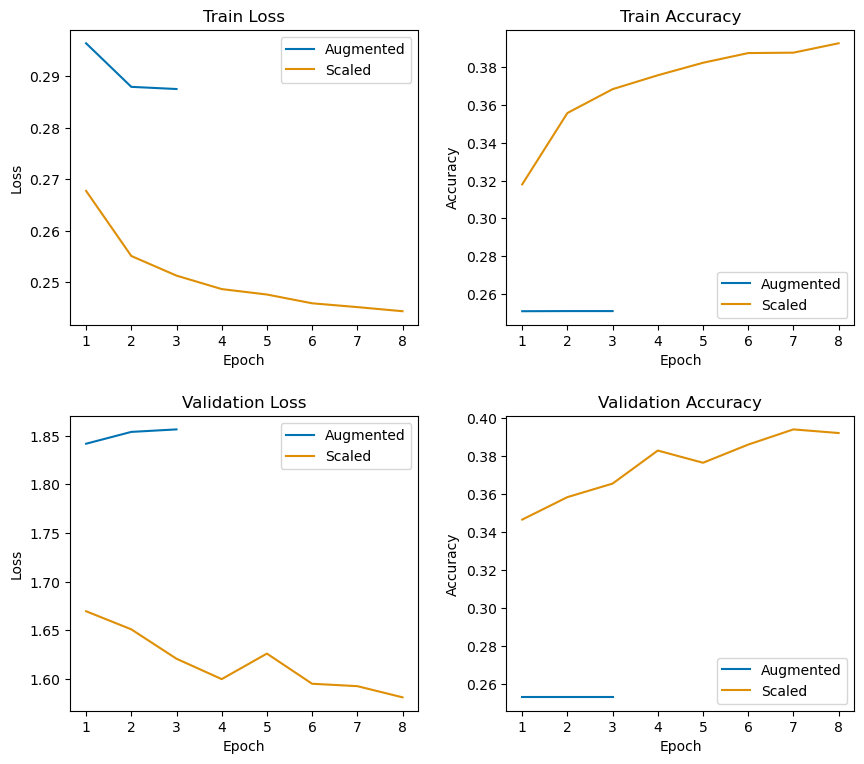

In [45]:
model_convergence(vgg_histories_dict)

We can see from the above plots the scaled model has converged quite well for all metrics with the curves levelling out steadily until our validation loss early stopping criteria was met after 8 epochs. The augmented model on the other hand stopped after only 3 epochs with minimal improvement seen, convergence is not entirely applicable here but the plots show the results to be reasonably stable within this short range. For the purpose of this study convergence is ok for both models.

#### Overfitting

Next we will check for model overfitting using our 'overfitting_check' function using the same dictionary of histories passed to our 'model_convergence' function above:

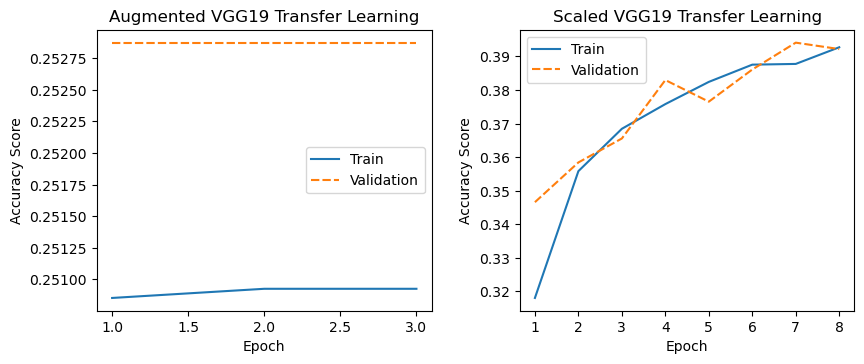

In [46]:
overfitting_check(vgg_histories_dict)

Neither of our models appear to be overfitting with train and validation accuracy scores matching each other quite closely. Again our augmented model does not really exhibit a trend as it stopped after 3 epochs.

#### Model Performance on Test Data

Even though these models appear to be poor predictors of our facial expressions, lets apply them to our test data and compare them using our 'compare_model_performance' function:

113/113 [==============================] - 57s 500ms/step - loss: 1.5926 - accuracy: 0.3862


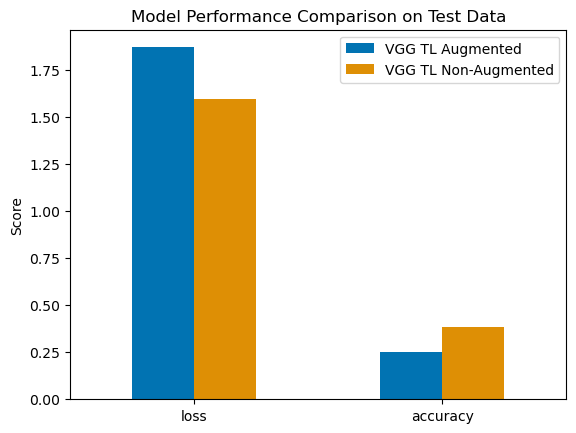

In [47]:
compare_model_performance({'VGG TL Augmented': vgg19_tl_aug_model, 'VGG TL Non-Augmented': vgg19_tl_model},
                          X_test_rescaled, 
                          y_test)

Poor results all round, our better 'scaled' model scoring only 38% with a very high loss of 1.6. No further investigation will be made into the performance of these models.

##### Conclusion

- Training on augmented data produces worse results.
- VGG19 model is not really helping us with this task, it may be more useful for object classification and not so much facial expressions.
- Note that we could run a single tweak run to adjust the weights for our problem however I worry this would be a computationally costly endeavour.

Our transfer learning models have performed very poorly and suggest a more custom approach trained specifically on our images is required. In light of this we will leave our transfer learning models and move on to create our own CNN's and train them on our data.

### Custom CNN's

A major consideration when designing the models in this section is to keep them small enough to be able to run locally without the need to use google collab or AWS. With this in mind, we will apply some guidelines from previous successful/famous models and use them as building blocks for our model:

1. Aggressive stemming at the start (Inspired by GoogLenet)
 - Greatly reduces the spatial size of our tensors to help reduce computation for the remainder of the network
2. Standardized convolutional/pooling combo blocks (First introduced in VGG architecture)
 - Follows the design principle of stacking conv+max_pooling blocks together:
     - Convolutional layers (3x3 window, stride 1, pad 1):
         - Two 3x3 layers have the same receptive field as a single 5x5 layer but has less learnable parameters and requires fewer flops and allows more nonlinear computation as activation functions can be used after each layer.
     - Followed by max pooling layer (2x2 window, stride 2, pad 0)
         - Doubling up our channels and halving the spatial size after our conv stages (groups of conv layers) halves our memory usage and maintains the same number of flops for the next conv stage.
3. Average Pooling at the end (Inspired by GoogLenet)
 - Instead of fully connected layers at the end (where a lot of the trainable parameters can come from), use average pooling  with just 1 fully connected layer to produce our 7 emotion categories.
 
With these design principles in mind, lets define functions for stemming blocks and convolutional blocks to use and basic building blocks for our models:

#### Building Blocks

Define our stemming block as a convolution followed by max pooling:

In [48]:
def stem_block(model, filters, input_shape = None):
    # specify shape for first layer, otherwise take output from last layer
    input_shape = input_shape if input_shape is not None else model.layers[-1].output_shape[1:]
    # Conv layer
    model.add(Conv2D(filters, 
                     kernel_size = (3, 3), 
                     strides = (1, 1), 
                     padding = 'valid', 
                     activation = 'relu', 
                     input_shape = input_shape))
    # Max pooling layer
    model.add(MaxPooling2D(pool_size = (2, 2), padding='valid'))

Define our convolutional block as a double convolution followed by max pooling. Note that both 'kernel_regularizer' and 'dropout_rate' are arguments for our 'conv_block' function as it facilitates their use in a hyperparameter search to try and improve overfitting in the latter part of this notebook.

In [49]:
def conv_block(model, filters, kernel_regularizer, dropout_rate):
    # double convolution with batch normalization and dropout
    for i in range(2):
        model.add(Conv2D(filters,
                         kernel_size = (3, 3),
                         strides = (1, 1), 
                         padding = 'same',
                         kernel_regularizer = kernel_regularizer))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Activation('relu'))
    # max pooling
    model.add(MaxPooling2D(pool_size = (2, 2), padding = 'valid'))

#### Modeling Approach

Using these building blocks, we will create 3 different CNN architectures. Out of the these, the most sucessful model will be analyzed further to try and make optimizations/improvements. 

#### Model Architectures

This section of the notebook follows the pattern of:
1. Define model architecture
2. Compile model
3. Fit model
4. Repeat steps 1-3 with different architectures

Thus, markdowns will be less frequent in this section.
Note we are using the same early stopping criteria as in our previous transfer learning modeling.

##### Model 1

In [100]:
CNN1 = Sequential()

# Stemming
stem_block(CNN1, filters = 16, input_shape = (48, 48, 1))
stem_block(CNN1, filters = 32)

# Conv layers, no regularization for now
conv_block(CNN1, filters = 64, kernel_regularizer = None, dropout_rate = 0.1)
conv_block(CNN1, filters = 128, kernel_regularizer = None, dropout_rate = 0.1)

# Global Average Pooling
CNN1.add(layers.GlobalAveragePooling2D())

# Dense softmax layer for predictions
CNN1.add(layers.Dense(7, activation = 'softmax')) 

# Print the model summary
CNN1.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_139 (Conv2D)         (None, 46, 46, 16)        160       
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 23, 23, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_140 (Conv2D)         (None, 21, 21, 32)        4640      
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_141 (Conv2D)         (None, 10, 10, 64)        18496     
                                                                 
 batch_normalization_94 (Bat  (None, 10, 10, 64)     

In [101]:
CNN1.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy', # as we have scalar target class
              metrics = ['accuracy'])

In [102]:
# fit model using scaled data:
history_1 = CNN1.fit(X_train_rescaled,
          y_train,
          validation_split = 0.2,
          callbacks = [early_stop],
          class_weight = class_weights,
          epochs = 12, 
          batch_size = 16)

Epoch 1/12
1436/1436 [==============================] - 44s 30ms/step - loss: 0.2544 - accuracy: 0.3630 - val_loss: 1.8191 - val_accuracy: 0.3337
Epoch 2/12
1436/1436 [==============================] - 44s 30ms/step - loss: 0.2137 - accuracy: 0.4706 - val_loss: 1.3158 - val_accuracy: 0.5017
Epoch 3/12
1436/1436 [==============================] - 49s 34ms/step - loss: 0.1948 - accuracy: 0.5129 - val_loss: 1.2886 - val_accuracy: 0.5265
Epoch 4/12
1436/1436 [==============================] - 48s 33ms/step - loss: 0.1817 - accuracy: 0.5487 - val_loss: 1.3893 - val_accuracy: 0.4848
Epoch 5/12
1436/1436 [==============================] - 42s 30ms/step - loss: 0.1729 - accuracy: 0.5717 - val_loss: 1.2020 - val_accuracy: 0.5505
Epoch 6/12
1436/1436 [==============================] - 41s 29ms/step - loss: 0.1635 - accuracy: 0.5930 - val_loss: 1.1590 - val_accuracy: 0.5721
Epoch 7/12
1436/1436 [==============================] - 54s 38ms/step - loss: 0.1554 - accuracy: 0.6159 - val_loss: 1.1574 -

Notes: Try less stemming at start, we may be reducing the spatial dimensions too much, is only 48x48 anyways, add an extra conv layer in the middle.

##### Model 2

In [103]:
CNN2 = Sequential()

# Stemming
stem_block(CNN2, filters = 16, input_shape = (48, 48, 1))

# Conv layers
conv_block(CNN2, filters = 32, kernel_regularizer = None, dropout_rate = 0.1)
conv_block(CNN2, filters = 64, kernel_regularizer = None, dropout_rate = 0.1)
conv_block(CNN2, filters = 128, kernel_regularizer = None, dropout_rate = 0.1)

# Global Average Pooling
CNN2.add(layers.GlobalAveragePooling2D())

# Dense softmax layer for predictions
CNN2.add(layers.Dense(7, activation = 'softmax')) 

# Print the model summary
CNN2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_145 (Conv2D)         (None, 46, 46, 16)        160       
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 23, 23, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_146 (Conv2D)         (None, 23, 23, 32)        4640      
                                                                 
 batch_normalization_98 (Bat  (None, 23, 23, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_98 (Dropout)        (None, 23, 23, 32)        0         
                                                                 
 activation_98 (Activation)  (None, 23, 23, 32)      

In [104]:
CNN2.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy', # as we have scalar target class
              metrics = ['accuracy'])

history_2 = CNN2.fit(X_train_rescaled,
          y_train,
          validation_split = 0.2,
          callbacks = [early_stop],
          class_weight = class_weights,
          epochs = 12, 
          batch_size = 16)

Epoch 1/12
1436/1436 [==============================] - 81s 55ms/step - loss: 0.2414 - accuracy: 0.3946 - val_loss: 1.8747 - val_accuracy: 0.3901
Epoch 2/12
1436/1436 [==============================] - 73s 51ms/step - loss: 0.2012 - accuracy: 0.5010 - val_loss: 1.3090 - val_accuracy: 0.5068
Epoch 3/12
1436/1436 [==============================] - 65s 45ms/step - loss: 0.1861 - accuracy: 0.5360 - val_loss: 1.3233 - val_accuracy: 0.5176
Epoch 4/12
1436/1436 [==============================] - 65s 45ms/step - loss: 0.1745 - accuracy: 0.5654 - val_loss: 1.1993 - val_accuracy: 0.5568
Epoch 5/12
1436/1436 [==============================] - 72s 50ms/step - loss: 0.1669 - accuracy: 0.5824 - val_loss: 1.1688 - val_accuracy: 0.5648
Epoch 6/12
1436/1436 [==============================] - 75s 52ms/step - loss: 0.1581 - accuracy: 0.6070 - val_loss: 1.2489 - val_accuracy: 0.5531
Epoch 7/12
1436/1436 [==============================] - 77s 54ms/step - loss: 0.1514 - accuracy: 0.6205 - val_loss: 1.3655 -

Notes: Try increasing the number of filters.

##### Model 3

Note the building of CNN3 has been wrapped in a function here for later use in an iterative optimization task. Note the inclusion of regularization_type and dropout_rate as arguments as these hyperparameters were chosen to attempt to improve our model. 

In [105]:
def CNN3_compiler(regularization_type, dropout_rate):
    
    '''Wraps architecture of CNN 3 in a function. Takes in hyperparameters and returns Keras model'''
    
    print(f"dropout_rate = {dropout_rate}, regularization_type = {regularization_type}")

    CNN3 = Sequential()

    # Stemming
    stem_block(CNN3, filters = 32, input_shape = (48, 48, 1))
    stem_block(CNN3, filters = 64)

    # Conv layers
    conv_block(CNN3, filters = 128, kernel_regularizer = regularization_type, dropout_rate = dropout_rate)
    conv_block(CNN3, filters = 256, kernel_regularizer = regularization_type, dropout_rate = dropout_rate)

    # Global Average Pooling
    CNN3.add(layers.GlobalAveragePooling2D())

    # Dense softmax layer for predictions
    CNN3.add(layers.Dense(7, activation = 'softmax'))
    
    CNN3.compile(optimizer = 'Adam',
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    return CNN3

In [106]:
CNN3 = CNN3_compiler(regularization_type = None, dropout_rate = 0.1)

# Print the model summary
CNN3.summary()

dropout_rate = 0.1, regularization_type = None
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_152 (Conv2D)         (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 23, 23, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_153 (Conv2D)         (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 10, 10, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_154 (Conv2D)         (None, 10, 10, 128)       73856     
                                                                 
 batch

In [107]:
history_3 = CNN3.fit(X_train_rescaled,
          y_train,
          validation_split = 0.2,
          callbacks = [early_stop],
          class_weight = class_weights,
          epochs = 12, 
          batch_size = 16)

Epoch 1/12
1436/1436 [==============================] - 139s 95ms/step - loss: 0.2523 - accuracy: 0.3723 - val_loss: 1.6264 - val_accuracy: 0.3976
Epoch 2/12
1436/1436 [==============================] - 125s 87ms/step - loss: 0.2070 - accuracy: 0.4850 - val_loss: 1.6168 - val_accuracy: 0.4096
Epoch 3/12
1436/1436 [==============================] - 139s 97ms/step - loss: 0.1882 - accuracy: 0.5323 - val_loss: 1.3201 - val_accuracy: 0.5247
Epoch 4/12
1436/1436 [==============================] - 128s 89ms/step - loss: 0.1743 - accuracy: 0.5672 - val_loss: 1.3485 - val_accuracy: 0.5005
Epoch 5/12
1436/1436 [==============================] - 144s 100ms/step - loss: 0.1628 - accuracy: 0.5928 - val_loss: 1.2217 - val_accuracy: 0.5442
Epoch 6/12
1436/1436 [==============================] - 144s 100ms/step - loss: 0.1508 - accuracy: 0.6254 - val_loss: 1.2379 - val_accuracy: 0.5604
Epoch 7/12
1436/1436 [==============================] - 133s 93ms/step - loss: 0.1386 - accuracy: 0.6548 - val_loss:

### Model Comparison

Now that we have 3 different trained models, let's compare them against one another to choose the best one to continue development.

#### Model Convergence

First let's check model convergence using the same 'model_convergence' function as before, first creating a dictionary of histories to pass in:

In [108]:
CNN_histories_dict = {'CNN1': history_1,
                      'CNN2': history_2,
                      'CNN3': history_3}

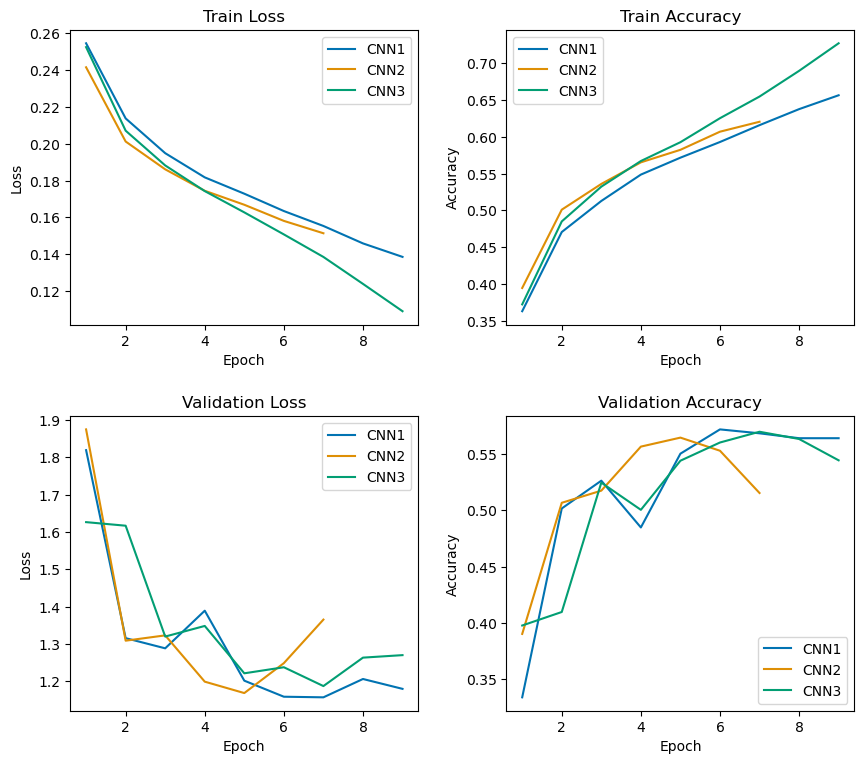

In [109]:
model_convergence(CNN_histories_dict)

Both the training loss and training accuracy for all models appears to be leveling out up to about the second epoch but then continues to improve linearly, this may suggest some over fitting to the training data. Validation loss and validation accuracy appear to converge with oscillations but do so satisfactorily.

#### Overfitting

Let's investigate our over fitting note from above using the same 'overfitting_check' as before:

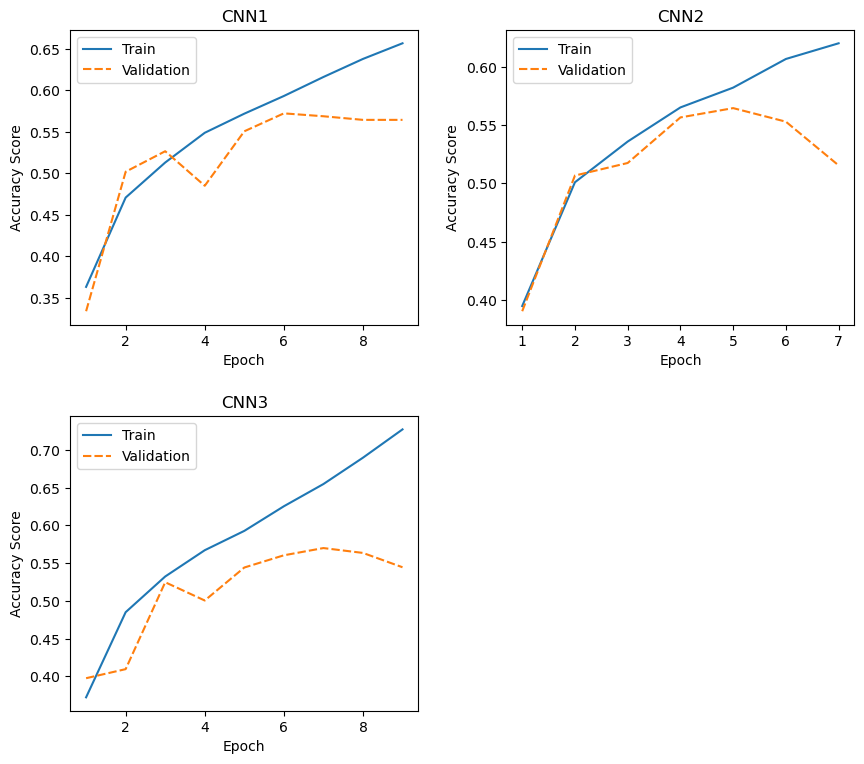

In [110]:
overfitting_check(CNN_histories_dict, 2)

It seems our concern was correct, all models are beginning to overfit after second epoch with the training accuracy increasing linearly and diverging from the validation accuracy which is seen to level off. Note that this effect is seen to be less pronounced for CNN 3 than the other 2 models with an unpward trend in the validation accuracy curve seen even after overfitting beings to occur.

#### Model Comparison

Score our 3 models on our test data:

In [111]:
CNN_models_dict = {'CNN 1': CNN1,
                   'CNN 2': CNN2,
                   'CNN 3': CNN3}

113/113 [==============================] - 5s 43ms/step - loss: 1.2863 - accuracy: 0.5489


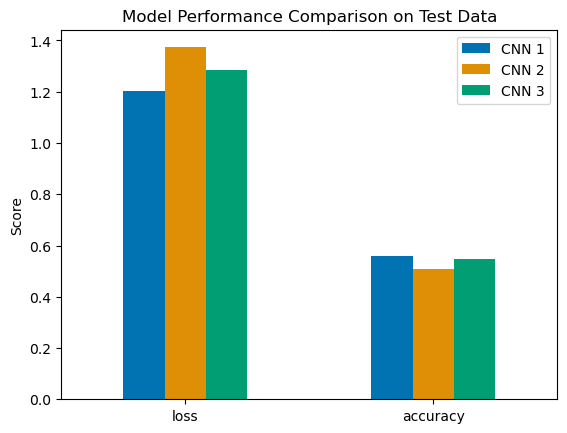

In [112]:
compare_model_performance(CNN_models_dict, X_test_rescaled,  y_test)

It appears 'CNN 3' model is the most sucessful, lets investigate how we can make improvements or optmizations to this model to first address overfitting to the training data. Note that although these models cannot be fairly compared while such strong overfitting is present, for the purpose of this notebook only 1 model will be chosen to move forward, hence the appraent best 'CNN 3' is selected as the most promising.

### Addressing Overfitting

Lets see if we can implement a mix of regularization and dropout to see if we can improve our results using CNN 3 by countering the overfitting seen. This will be done using a pseudo custom gridsearch over a range of both of these aforementioned hyperparameters.

#### Hyper Parameter Optimization

The inclusion of regularization_type and dropout_rate as arguments to our function (as mentioned in section XX during the creation of our convolutional building block function) facilitates the search performed here. These 2 parameters will be searched over with a new model being created for each hyperparameter combination, hence the need for them as arguments to our functions. Note that this a very simple implementation of these hyperparams as they are being applied to every convolution within our convolutional block with no variation through our CNN architecture.

Note that in order to keep the runtime reasonable we will take a 10% sample of our training data (reduction from approx 28,000 examples down to 2,800). This may prove to be counterproductive or suggest a stronger use of these 'overfitting-combating' hyperparameters than necessary as training on small dataset can itself contribute to overfitting.

A relatively coarse range dropout_rate has been tested here, again keeping runtime in mind. I am not as concerned with fully optimizing model performance here as this is more of an exploratory notebook.

Note a GridSearch was initially attempted to be used here instead of a custom nested loop, however issues arose related to incorporating early stopping based on validation scores as these are not readily available due to the inherent internal handling of cross folds in the GridSearch function. Details can be found in the Appendix section at the end of this notebook.

In [63]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
regularization_types = [None, 'l1', 'l2']
indicies = np.random.choice(len(y_train), int(len(y_train)*0.1), replace = False)

# new early stop criteria with higher patience to account increased irregularity of results when dealing with small dataset
early_stop_hyperparam_search = EarlyStopping(monitor = 'val_loss', 
                                            patience = 4, 
                                            mode = 'min', 
                                            verbose = 1)

# create empty dictionary to store results
results_dict = {}

for regularization_type in regularization_types:
    # initialize nested layer in dict
    results_dict[str(regularization_type)] = {} # convert 'None' to string for data storage
    
    for dropout_rate in dropout_rates:
        # create and compile
        model = CNN3_compiler(dropout_rate = dropout_rate, regularization_type = regularization_type)
    
        # fit
        history = model.fit(X_train_rescaled[indicies],
                           y_train[indicies],
                           validation_split = 0.2,
                           callbacks = [early_stop_hyperparam_search],
                           class_weight = class_weights,
                           epochs = 24, 
                           batch_size = 16)
        
        # store histories in dict
        results_dict[str(regularization_type)][dropout_rate] = history 

dropout_rate = 0.0, regularization_type = None
Epoch 1/24
144/144 [==============================] - 12s 75ms/step - loss: 0.3116 - accuracy: 0.2404 - val_loss: 1.8436 - val_accuracy: 0.1812
Epoch 2/24
144/144 [==============================] - 11s 74ms/step - loss: 0.2720 - accuracy: 0.3158 - val_loss: 1.8479 - val_accuracy: 0.2666
Epoch 3/24
144/144 [==============================] - 11s 74ms/step - loss: 0.2552 - accuracy: 0.3528 - val_loss: 1.8652 - val_accuracy: 0.2038
Epoch 4/24
144/144 [==============================] - 11s 74ms/step - loss: 0.2342 - accuracy: 0.4177 - val_loss: 1.6778 - val_accuracy: 0.3519
Epoch 5/24
144/144 [==============================] - 11s 74ms/step - loss: 0.2163 - accuracy: 0.4669 - val_loss: 1.7651 - val_accuracy: 0.2997
Epoch 6/24
144/144 [==============================] - 11s 76ms/step - loss: 0.2004 - accuracy: 0.5065 - val_loss: 2.1887 - val_accuracy: 0.2073
Epoch 7/24
144/144 [==============================] - 11s 74ms/step - loss: 0.1788 - accu

144/144 [==============================] - 11s 77ms/step - loss: 0.1901 - accuracy: 0.5270 - val_loss: 1.5729 - val_accuracy: 0.4094
Epoch 13/24
144/144 [==============================] - 11s 76ms/step - loss: 0.1810 - accuracy: 0.5475 - val_loss: 1.4532 - val_accuracy: 0.4652
Epoch 14/24
144/144 [==============================] - 11s 76ms/step - loss: 0.1710 - accuracy: 0.5740 - val_loss: 1.4571 - val_accuracy: 0.4704
Epoch 15/24
144/144 [==============================] - 11s 77ms/step - loss: 0.1655 - accuracy: 0.5867 - val_loss: 1.5462 - val_accuracy: 0.4443
Epoch 16/24
144/144 [==============================] - 11s 77ms/step - loss: 0.1585 - accuracy: 0.5984 - val_loss: 1.4775 - val_accuracy: 0.4913
Epoch 17/24
144/144 [==============================] - 11s 76ms/step - loss: 0.1516 - accuracy: 0.6267 - val_loss: 1.7411 - val_accuracy: 0.3519
Epoch 17: early stopping
dropout_rate = 0.5, regularization_type = None
Epoch 1/24
144/144 [==============================] - 12s 78ms/step - 

Epoch 6/24
144/144 [==============================] - 12s 81ms/step - loss: 1.4178 - accuracy: 0.2409 - val_loss: 2.9310 - val_accuracy: 0.2648
Epoch 7/24
144/144 [==============================] - 12s 81ms/step - loss: 1.4252 - accuracy: 0.2409 - val_loss: 2.9505 - val_accuracy: 0.2648
Epoch 8/24
144/144 [==============================] - 11s 80ms/step - loss: 1.4361 - accuracy: 0.2409 - val_loss: 2.9644 - val_accuracy: 0.2648
Epoch 9/24
144/144 [==============================] - 12s 81ms/step - loss: 1.4442 - accuracy: 0.2409 - val_loss: 2.9677 - val_accuracy: 0.2648
Epoch 10/24
144/144 [==============================] - 12s 81ms/step - loss: 1.4501 - accuracy: 0.2409 - val_loss: 2.9791 - val_accuracy: 0.2648
Epoch 10: early stopping
dropout_rate = 0.5, regularization_type = l1
Epoch 1/24
144/144 [==============================] - 13s 82ms/step - loss: 32.8339 - accuracy: 0.2017 - val_loss: 6.2109 - val_accuracy: 0.2648
Epoch 2/24
144/144 [==============================] - 12s 81ms/s

144/144 [==============================] - 11s 79ms/step - loss: 0.4074 - accuracy: 0.2269 - val_loss: 1.9162 - val_accuracy: 0.2648
Epoch 12/24
144/144 [==============================] - 11s 79ms/step - loss: 0.4055 - accuracy: 0.2221 - val_loss: 1.9877 - val_accuracy: 0.1620
Epoch 13/24
144/144 [==============================] - 11s 78ms/step - loss: 0.4014 - accuracy: 0.2213 - val_loss: 1.9190 - val_accuracy: 0.2648
Epoch 14/24
144/144 [==============================] - 11s 79ms/step - loss: 0.4003 - accuracy: 0.2217 - val_loss: 1.9218 - val_accuracy: 0.2648
Epoch 14: early stopping
dropout_rate = 0.4, regularization_type = l2
Epoch 1/24
144/144 [==============================] - 13s 80ms/step - loss: 3.1265 - accuracy: 0.2204 - val_loss: 2.8396 - val_accuracy: 0.1725
Epoch 2/24
144/144 [==============================] - 11s 78ms/step - loss: 0.6765 - accuracy: 0.2300 - val_loss: 2.2693 - val_accuracy: 0.1725
Epoch 3/24
144/144 [==============================] - 11s 79ms/step - loss

Lets dig into our results dictionary and pull out the best validation accuracy scores to create a heat map:

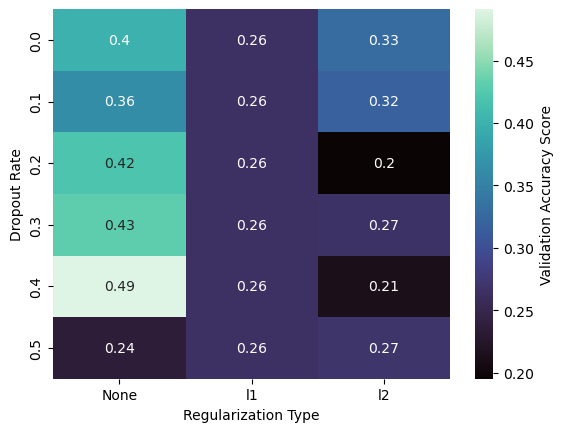

In [64]:
val_accuracy_dict = {} # initialize a new dict to store max accuracies

# iterate through our nested results dict
for reg_type in results_dict.keys():
    val_accuracy_dict[reg_type] = {}
    for dropout in results_dict[reg_type].keys():
        # retrieve and store max validation accuracy store for each hyperparam combination
        val_accuracy_dict[reg_type][dropout] = max(results_dict[reg_type][dropout].history['val_accuracy'])

# plot
sns.heatmap(pd.DataFrame(val_accuracy_dict), # convert to dataframe for easy input into heatmap
            annot = True, 
            cmap = "mako", 
            cbar_kws = {'label': 'Validation Accuracy Score'})
plt.xlabel('Regularization Type')
plt.ylabel('Dropout Rate')
plt.show()

It seems both of our regularization techniques have performed quite poorly while using dropout alone looks promising. Lets take a look at our overfitting curves to see what happened during training of these models:

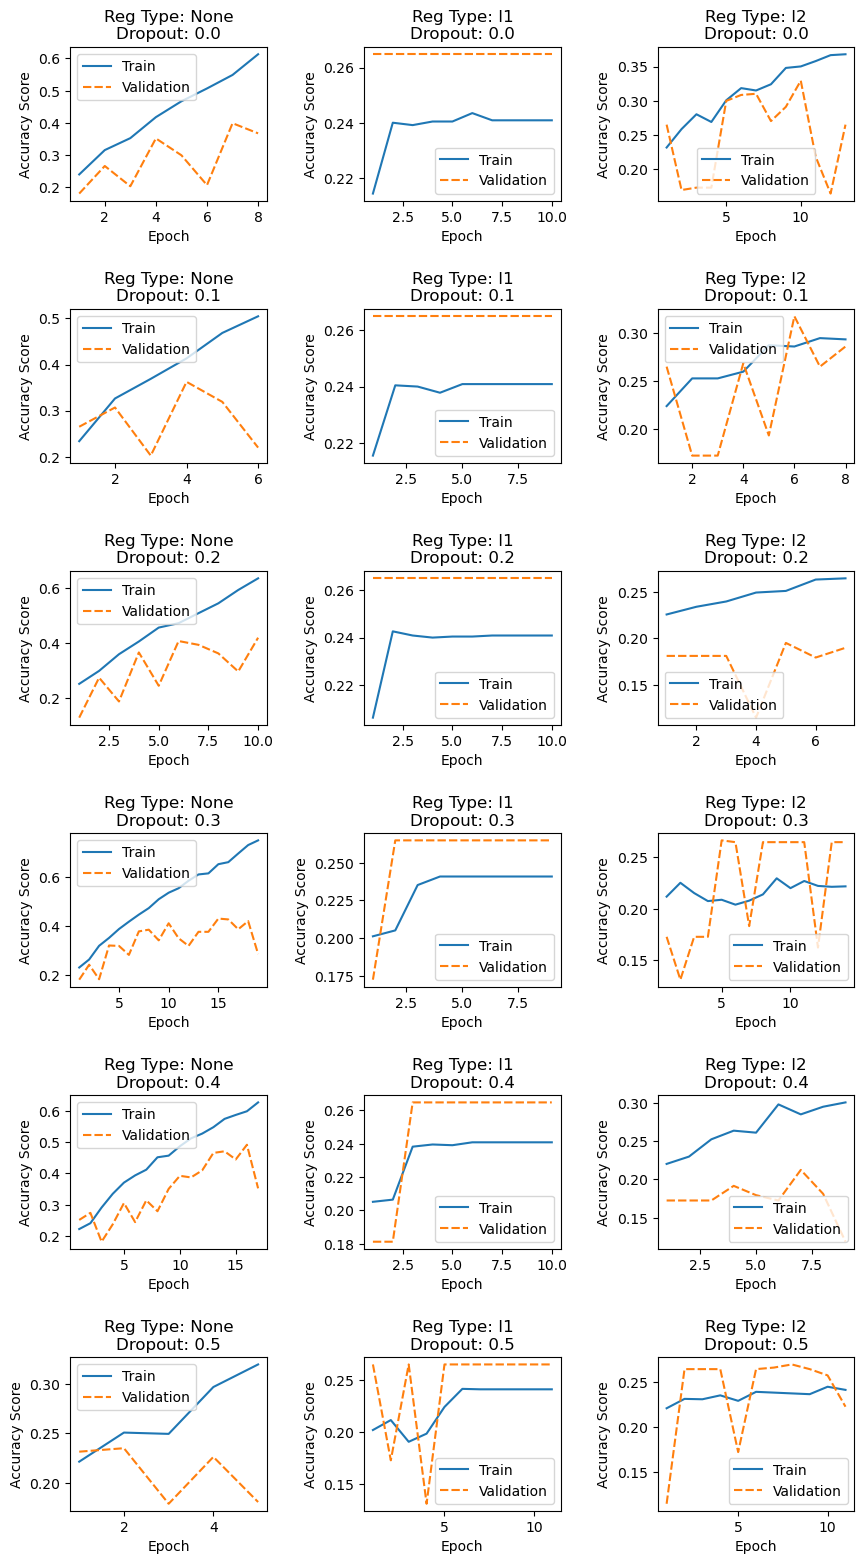

In [65]:
# Rearrange and rename keys of our results_dict to pass to out overfitting function:
results_dict_reformat = {}
for dropout in dropout_rates:
    for reg_type in regularization_types:
        results_dict_reformat['Reg Type: ' + str(reg_type) + '\nDropout: ' + str(dropout)] = results_dict[str(reg_type)][dropout]
        
# pass to our overfitting_check function:
overfitting_check(results_dict_reformat, 3)

It seems both L1 and L2 regularization are penalizing our higher models weights too heavily with a detrimental effect on our model. The model's ability to learn the training data for all our L1 and L2 cases levels out very quickly with only minor improvements across all epochs. This suggests that both the feature selection effect of L1 regularization (by forcing some weights to become zero) and the decreased impact of singular nodes defined as highly influential due to L2 regularization (as l2 imposes a pentaly based on the squared value of the weights) are disallowing our model to effectively learn the required difference in facial expressions between classes. By far the superior results are those with some dropout and no regularization. Based on the above plot we will choose a dropout rate of 0.3 with no regularization as our best hyperparameter combination. A dropout rate of 0.3 with no regularization seems to create a validation accuracy curve that most closely follows the train accuracy curve. Hopefully the increase in samples when we retain our CNN using this dropout will ease the pertubations seen in the accuracy curve as well as help with the overfitting still present. 

#### Retrain CNN 3

Retrain our CNN 3 model on all available training data with chosen hyperparameters :

In [86]:
# manually input chosen hyperparams into CNN 3 model builder function
CNN3_optimized = CNN3_compiler(regularization_type = None, dropout_rate = 0.4)

# define new early stop criteria for this training run
early_stop_CNN3_optimized = EarlyStopping(monitor = 'val_loss', 
                                          patience = 5, # increase by one from hyperparam search as upwards trend was apparent at training termination
                                          mode = 'min', 
                                          restore_best_weights = True, # add in restore best weights in case we overshoot and end up overfitting at training termination
                                          verbose = 1)

# fit model
CNN3_optimized_history = CNN3_optimized.fit(X_train_rescaled,
                                            y_train,
                                            validation_split = 0.2,
                                            callbacks = [early_stop_CNN3_optimized],
                                            class_weight = class_weights,
                                            epochs = 24, # effect of increased sample size on convergence is unknown, leave at 24 (same as hyperparam search run)
                                            batch_size = 16)

dropout_rate = 0.4, regularization_type = None
Epoch 1/24
1436/1436 [==============================] - 120s 83ms/step - loss: 0.2702 - accuracy: 0.3347 - val_loss: 1.5408 - val_accuracy: 0.3779
Epoch 2/24
1436/1436 [==============================] - 118s 82ms/step - loss: 0.2183 - accuracy: 0.4569 - val_loss: 1.4397 - val_accuracy: 0.4584
Epoch 3/24
1436/1436 [==============================] - 119s 83ms/step - loss: 0.2017 - accuracy: 0.4987 - val_loss: 1.3505 - val_accuracy: 0.5197
Epoch 4/24
1436/1436 [==============================] - 119s 83ms/step - loss: 0.1909 - accuracy: 0.5241 - val_loss: 1.3273 - val_accuracy: 0.4918
Epoch 5/24
1436/1436 [==============================] - 118s 82ms/step - loss: 0.1849 - accuracy: 0.5380 - val_loss: 1.2835 - val_accuracy: 0.5246
Epoch 6/24
1436/1436 [==============================] - 119s 83ms/step - loss: 0.1776 - accuracy: 0.5594 - val_loss: 1.2576 - val_accuracy: 0.5453
Epoch 7/24
1436/1436 [==============================] - 120s 84ms/step 

This exceeded the number of epochs I was expecting it to use, lets see if we successfully addressed our overfitting issue:

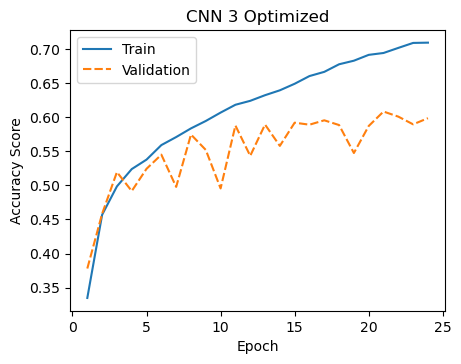

In [87]:
CNN3_optimized_history_dict = {'CNN 3 Optimized': CNN3_optimized_history}
overfitting_check(CNN3_optimized_history_dict)

As expected we are seeing less sporadic oscillations in our validation accuracy curve due to the increased number of samples trained on compared to our hyperparameter search run with the same hyperparameters. That being said, we are still overfitting after about the 6th epoch even with our new dropout rate of 0.3 and using all of the available data for training. At this point I am unsure how we can address this, let's move on and take a deeper look at model performance via a model evalulation.

#### Model Evaluation

Before we suggest improvements, lets better understand the performance of our model. First look at our classification report and confusion matrix:

In [ ]:
classification_report_generator(CNN3_optimized, X_test_rescaled, y_test)

Observations:
1. We are getting zeroes across the board for class 1 (disgust).
2. Precision and recall scores are reasonably even for most classes with the exception of classes 2 (fear) and 6 (neutral).
3. Class 2 has the lowest f1 score of 0.37. I am not particular favouring precision or recall for this project. 

Let's see what additonal insights a confusion matrix may give us:

113/113 [==============================] - 4s 37ms/step


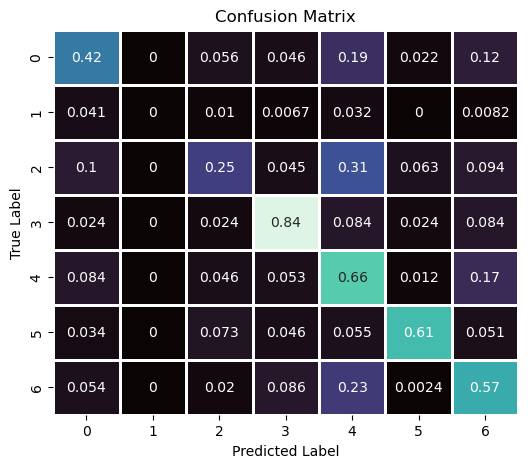

In [89]:
confusion_matrix_generator(CNN3_optimized, X_test_rescaled, y_test)

This matrix is reasonable good with relatively high proportions along the diagonal, however two main issues are apparrent from studying this plot:
1. No images are being predicted as emotion class 1 (disgust). This class was by far our minority class in our dataset making up only approx 1.5% of our training dataset. From what I can see this class is also somewhat ambiguous and difficult to classify, even for myself. Efforts to improve this model will not be focused here.
2. A resonably large number of our images are being incorrectly predicted as classes 0 (angry) and 4 (sad). Our highest offender here is class 2's (fear) being predicted as class 4 (sad) as evident as our largest 'off-diagonal' value. This seems like our biggest potential improvement we could make, let's investigate this further.

#### Misclassification Investigation

Investigate an example of a our worst offender (class 2, fear) being predicted as class 4 (sad). Lets isolate it to one example and follow the image through the layers and visaulize the activations:

113/113 [==============================] - 5s 37ms/step


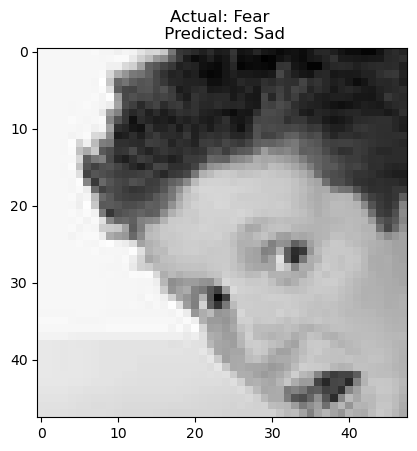

In [99]:
# calculate the predicted labels for each test image:
predict_probas = CNN3_optimized.predict(X_test_rescaled)
y_predict = np.argmax(predict_probas, axis = 1)

# define our constraints
actual_class = 2
predicted_class = 4

# find the first example of the above mis-classification
for i, label in enumerate(y_predict): # iterate through predictions array
    if y_predict[i] == predicted_class and y_test.iloc[i] == actual_class: # find instance that matches constariants above
        image = X_test_rescaled[i] # set as our image to investigate
        break
        
# show image
plt.imshow(image, cmap = 'gray')
plt.title(f'Actual: {emotion_dict[actual_class]} \n Predicted: {emotion_dict[predicted_class]}')
plt.show()

Run this image through an 'activation_model' and plot the activations from each of our layers:

1/1 [==============================] - 0s 141ms/step


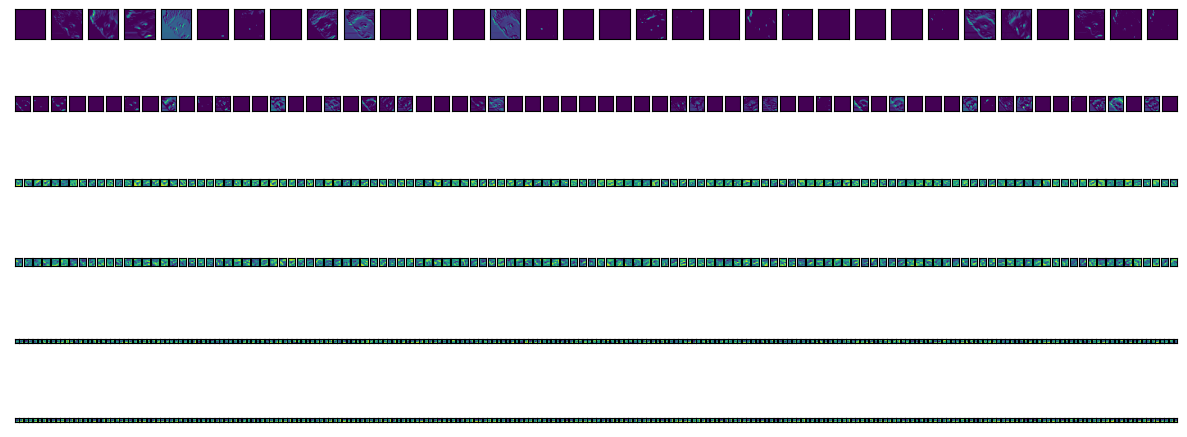

In [91]:
# reshape image for model
image = image.reshape(1, 48, 48, 1)

# define model
model = CNN3_optimized

# Create a model with intermediate layer activations
layer_names = [layer.name for layer in model.layers if isinstance(layer, layers.Conv2D)]
activation_model = Model(inputs = model.input,
                        outputs = [model.get_layer(layer_name).output for layer_name in layer_names])

# make a prediction based on the single image
activations = activation_model.predict(image)

# plot the activations
plt.figure(figsize = (15, 6))
for i, activation_layer in enumerate(activations):
    num_filters = activation_layer.shape[-1]
    for j in range(num_filters):
        ax = plt.subplot(len(layer_names), num_filters, i * num_filters + j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(activation_layer[0, :, :, j], cmap = 'viridis')

plt.show()

Erronously, I jumped into coding this without thinking about the output. This is too complex for me to analyze manually.

We will leave model improvements here and move on to model comparison.

#### Model Comparison

113/113 [==============================] - 4s 34ms/step - loss: 1.1214 - accuracy: 0.5871


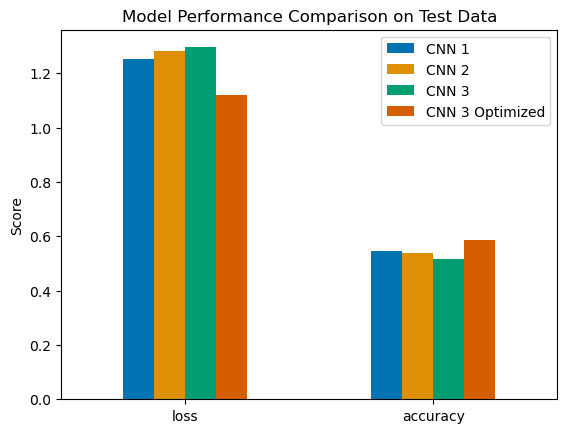

In [92]:
CNN_models_dict_V2 = {'CNN 1': CNN1,
                      'CNN 2': CNN2,
                      'CNN 3': CNN3,
                      'CNN 3 Optimized': CNN3_optimized}

# note some re-evaluation of past models here is ok, short runtime
compare_model_performance(CNN_models_dict_V2, X_test_rescaled,  y_test)

Well at least this shows we did get a better result by improving the overfitting, although it is slight. Let's see how our models stack up against other competiton entries.

## Private Test Set Competition

Now that we have all of our models, lets see how they fair against the rest of the kaggle entries. First import the leaderboard and look at the top submissions:

In [93]:
leaderboard_df = pd.read_csv('data/leaderboard.csv')

In [94]:
leaderboard_df.head()

,Rank,TeamId,TeamName,LastSubmissionDate,Score,SubmissionCount,TeamMemberUserNames
0,1,39614,RBM,2013-05-23 16:12:26,0.71161,5,neocortex
1,2,39836,Unsupervised,2013-05-24 18:32:35,0.69267,8,"chetanra,unsupervised"
2,3,42018,Maxim Milakov,2013-05-24 20:07:41,0.68821,7,milakov
3,4,41161,Radu+Marius+Cristi,2013-05-24 14:35:49,0.67483,6,"brainsignals,mariuspopescu,raducu"
4,5,41552,Lor.Voldy,2013-05-21 19:29:59,0.65254,2,lorvoldy


Next define the competition dataset and apply the same steps as our previous train and test data:

In [95]:
# define data subset as new df
df_comp = df_reshaped[df_reshaped[' Usage'] == 'PrivateTest']

# apply rescaling
df_comp_rescaled = df_comp.copy()
df_comp_rescaled[' pixels'] = df_comp_rescaled[' pixels'] / 255.0

# define X and y data
X_comp_rescaled = np.array(df_test_rescaled[' pixels'].to_list())
y_comp = df_test_rescaled['emotion']

Next lets evaluate our models on this competition data. Note only accuracy scores are stored here as that is the only metric by which the other entries are ranked.

In [96]:
# create a dictionary to store competition results
competition_dict = {}

# create dict of models
models = {'VGG19 Transfer Learning': vgg19_tl_model, 
          'CNN1': CNN1, 
          'CNN2': CNN2, 
          'CNN3': CNN3,
          'CNN3 Optimized': CNN3_optimized}

# iterate through dict
for model_name, model in zip(models.keys(), models.values()):
    # evaluate model and store accuracy scores in dict
    competition_dict[model_name] = model.evaluate(X_comp_rescaled, y_comp)[1]
    
competition_dict

113/113 [==============================] - 4s 37ms/step - loss: 1.1214 - accuracy: 0.5871


{'VGG19 Transfer Learning': 0.38617998361587524,
 'CNN1': 0.5472276210784912,
 'CNN2': 0.5380328893661499,
 'CNN3': 0.516021192073822,
 'CNN3 Optimized': 0.5870715975761414}

Visulaize the relative standings of our models within the field of entries:

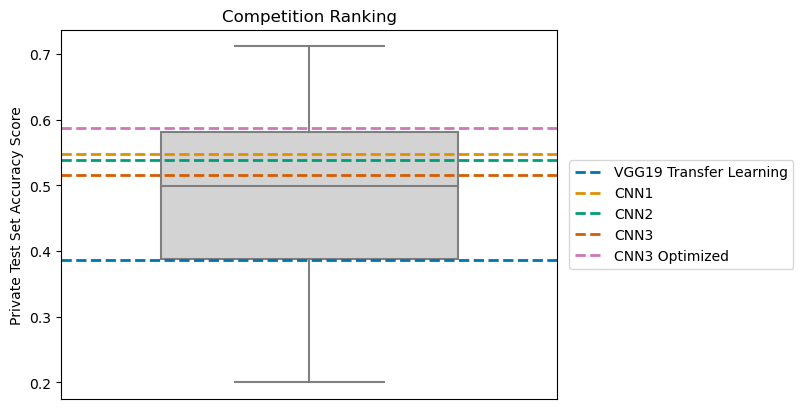

In [97]:
# plot boxplot as base plot
sns.boxplot(data = leaderboard_df['Score'], color = 'lightgray', width = 0.6)

# iterate through competetion dictionary to overlay model scores
colors = sns.color_palette('colorblind', len(competition_dict))
for model, color in zip(competition_dict, colors):  
    plt.axhline(y = competition_dict[model], linestyle = '--', linewidth = 2, label = model, color = color)
plt.legend(loc = 'center left', bbox_to_anchor = (1.01, 0.5))
plt.title('Competition Ranking')
plt.ylabel('Private Test Set Accuracy Score')
plt.xticks([])
plt.show()

Seems like our best models did reasonably well with our optimized CNN 3 model placing just above the upper quartile. Lets place our best model within the entries:

In [98]:
# pull best model and score from results dict:
best_model, best_score = max(competition_dict.items(), key = lambda x: x[1])

# calculate placing using bisect (only works on ascending order)
leaderboard_scores = sorted(leaderboard_df['Score'].to_list()) # experienced issues with pd series and bisect, used list, sort in acsending order
place = len(leaderboard_scores) - bisect_left(leaderboard_scores, best_score) # reverse indexing to find placing

print(f'Best model was \'{best_model}\' placing {place}th out of {len(leaderboard_scores)} entries with a score of {round(competition_dict[best_model]*100, 2)}%')
# note: leaderbard rounded to 5dp no need to account for same score occuring

Best model was 'CNN3 Optimized' placing 13th out of 56 entries with a score of 58.71%


## Conclusion

As a brief summary of the workflow and results of this notebook, we:
1. Loaded in, breify examined and reshaped our image data
2. Applied image augmentation to create a separate augmented training dataset
3. Applied transfer learning of the VGG19 network trained on the ImageNet dataset. We applied both the un-augmented (scaled only) and augmented dataset to this model for training howver both approaches were unsuccessful scoring only 38% and 25% test set accuracies respectively, suggesting:
     - Transfer learning was not useful for our problem
     - Image augmentation was highly detrimental to our dataset
4. We design three custom CNN's and trained them on our dataset
5. Out of these three CNN's the most successful (CNN 3 with 57.8% test set accuracy) was chosen for further improvement
6. We ran a search over different regularization types and dropout rates to see which combination would best help us address overfitting. We found that no regularization and a dropout rate of 0.3 worked best although some overfitting was still present and increased our test set accuracy by only 2%.
7. Further model evaluation was conducted with an attmept at understanding the activation of a mis-classified image, however this was deemed to complex and not continued.
8. All models were evaluated on the competition data set with our most successful model (our CNN 3 model with reduced overfitting) scoring 60.3% placing 11th out of 56 entries.


### Self Evaluation and Notes for Potential Future Work:
We did not do a good job of improving our model past trying to address overfitting. Perhaps a better approach and bookmark for future work could be to use a parameter search to optimize our CNN architecture. Additionally I would have been interested in testing the use of augmented data on our custom CNN's to challenge the assumption made that 'data augmentation was detrimental to our transfer learning model and is therefore not useful for our other models'. Nonetheless as a first notebook on CNN's we have learned much and highly enjoyed working on this project.

One major point I would like to make upon revision of this project was the erronous use of the VGG19 architecture used for transfer learning in the first section of modeling. The plot below (retrieved from https://theaisummer.com/cnn-architectures/) shows the spread of different famous CNN architectures with the y axis showing the classification accuracy on the ImageNet dataset, the x axis showing the number of floating point operations per second (flops, a measure of model complexity) and the radius of each circle representing the number of learnable parameters within the model. This plot clearly shows that VGG19 is an outdated model with low accuracy, high number of flops and very high number of parameters. Compared to more modern architectures we could have saved ourselves a lot of computation time during our transfer learning and likey achieved better results. That being said, we will likely not apply a different model via transfer learning in this project. As evident in the extremely poor results of the transfer learning (even though a better model could have been chosen), I believe a model needs to be trained specifically in this data to perform well. A further note that in keeping with the low computational requirement of the models in this notebook, one of these more modern architectures, although much more efficient than VGG19, will not be trained and used for predictions as part of this project.

![Deep Learning Architectures](https://theaisummer.com/static/dfad9981c055b1ba1a37fb3d34ccc4d8/a1792/deep-learning-architectures-plot-2018.png)

The number of computational expense in our most successful model 'CNN3_optimized' can be calculated using the 'get_flops' function:

In [79]:
flops = get_flops(CNN3_optimized, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 0.106 G


This is considerably less than almost every architecture on the above plot. There are some exceptionally inexpensive models typically built for mobile patforms such as ShuffleNet and MobileNet that could be explored and trained on our dataset as part of future work.

## Appendix

### Evidence of a Failed GridSearch Implementation

This code was the initial attempt to search over hyperparameters to address overfitting of our model. Below is a brief description of the intent, followed by the code block, and finally the issues that arose.

The attempted use of a gridsearch here may have been somewhat redundant as one of the nice advantages is that it handles cross folds internally, however as we want to record and utilize the validation loss metric for our early stopping criteria, we have disabled this aspect of the gridsearch and instead manually fed in a simple singular 80/20 train/validation split. Note the early stopping use validation loss is key as we are trying to optimize for overfitting so should ideally stop training once this metric ceases to increase.

Note pertaining to code block below: <br>
Changing the param_grid values below to tuples helped get rid of an apparent bug in sk-learn giving error: "*Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001856332E2E0>, as the constructor either does not set or modifies parameter dropout_rate*". Fix pulled from stack overflow, unsure why this works but have implemented here with good results.

In [80]:
'''
# increased epochs as an educated guess with inclusion of regularization and/or increased dropout rates:
model = KerasClassifier(build_fn = CNN3_compiler, epochs = 16, batch_size = 16) 

# note use of tuples here instead of lists, see markdown above for details
param_grid = {'dropout_rate': (0.0, 0.1, 0.2, 0.3, 0.4, 0.5),
              'regularization_type': (None, 'l1', l2')}

# take a 10% sample of data to reduce runtime
indicies = np.random.choice(len(y_train), int(len(y_train)*0.1), replace = False)

# in order to record val_loss metric to use early stopping to avoid over fitting during training, we will not use 
# gridsearch's built in CV as validation loss/accuracy is not recorded. Instead we will split the data ourselves:
X_train_rescaled_split, X_val_rescaled, y_train_split, y_val = train_test_split(X_train_rescaled[indicies],
                                                                                y_train[indicies], 
                                                                                test_size = 0.2)

grid = GridSearchCV(estimator = model, param_grid = param_grid) # cross validation is disabled by default

grid_result = grid.fit(X_train_rescaled_split,
                       y_train_split,
                       validation_data = (X_val_rescaled, y_val), # manually add in validation data here
                       callbacks = [early_stop], # use same early stopping criteria as before
                       class_weight = class_weights) # making assumption that weights still valid for random sample 
'''

"\n# increased epochs as an educated guess with inclusion of regularization and/or increased dropout rates:\nmodel = KerasClassifier(build_fn = CNN3_compiler, epochs = 16, batch_size = 16) \n\n# note use of tuples here instead of lists, see markdown above for details\nparam_grid = {'dropout_rate': (0.0, 0.1, 0.2, 0.3, 0.4, 0.5),\n              'regularization_type': (None, 'l1', l2')}\n\n# take a 10% sample of data to reduce runtime\nindicies = np.random.choice(len(y_train), int(len(y_train)*0.1), replace = False)\n\n# in order to record val_loss metric to use early stopping to avoid over fitting during training, we will not use \n# gridsearch's built in CV as validation loss/accuracy is not recorded. Instead we will split the data ourselves:\nX_train_rescaled_split, X_val_rescaled, y_train_split, y_val = train_test_split(X_train_rescaled[indicies],\n                                                                                y_train[indicies], \n                                    

Issues with above code block:

It trains 5 separate models (up to 16 training epochs plus a single validation run) for every hyperparameter combination. Strangley, this happens even though cv is none and the results of each of the 5 models for each hyperparameter combination are very different. I beleive this may be due to a discord between the implementation of early stopping here and the way GridSearch handles cross validation. In terms of outputs I can access the correct best params from the GridSearch but only the history of the last run (5th out 5 for that hyperparameter combination) is saved (i.e best_params does not align with the recorded history).